## AuxTel Mount fails - 02-Jun-21

In this notebook, investigate mount tracking on 25-May-21

In [1]:
import sys, time, os, asyncio

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time, TimeDelta
from lsst_efd_client import EfdClient
from lsst.daf.persistence import Butler

In [2]:
# Get EFD client and bring in Lupton's unpacking code
client = EfdClient('ldf_stable_efd')
#client = EfdClient('summit_efd')

def merge_packed_time_series(packed_dataframe, base_field, stride=1, 
                             ref_timestamp_col="cRIO_timestamp", internal_time_scale="tai"): 
    """Select fields that are time samples and unpack them into a dataframe.
            Parameters
            ----------
            packedDF : `pandas.DataFrame`
                packed data frame containing the desired data
            base_field :  `str`
                Base field name that will be expanded to query all
                vector entries.
            stride : `int`, optional
                Only use every stride value when unpacking.  Must be a factor
                of the number of packed values.
                (1 by default)
            ref_timestamp_col : `str`, optional
                Name of the field name to use to assign timestamps to unpacked
                vector fields (default is 'cRIO_timestamp').
            internal_time_scale : `str`, optional
                Time scale to use when converting times to internal formats
                ('tai' by default). Equivalent to EfdClient.internal_scale
        Returns
            -------
            result : `pandas.DataFrame`
                A `pandas.DataFrame` containing the results of the query.
            """
    
    packed_fields = [k for k in packed_dataframe.keys() if k.startswith(base_field)]
    packed_fields = sorted(packed_fields, key=lambda k: int(k[len(base_field):]))  # sort by pack ID
    npack = len(packed_fields)
    if npack%stride != 0:
        raise RuntimeError(f"Stride must be a factor of the number of packed fields: {stride} v. {npack}")
    packed_len = len(packed_dataframe)
    n_used = npack//stride   # number of raw fields being used
    output = np.empty(n_used*packed_len)
    times = np.empty_like(output, dtype=packed_dataframe[ref_timestamp_col][0])
    
    if packed_len == 1:
        dt = 0
    else:
        dt = (packed_dataframe[ref_timestamp_col][1] - packed_dataframe[ref_timestamp_col][0])/npack
    for i in range(0, npack, stride):
        i0 = i//stride
        output[i0::n_used] = packed_dataframe[f"{base_field}{i}"]
        times[i0::n_used] = packed_dataframe[ref_timestamp_col] + i*dt
     
    timestamps = Time(times, format='unix', scale=internal_time_scale).datetime64
    return pd.DataFrame({base_field:output, "times":times}, index=timestamps)

In [3]:
# Still using Gen2 for this simple task
REPO_DIR = '/project/shared/auxTel'
butler = Butler(REPO_DIR)
dayObs = '2021-05-25'

<ipython-input-3-81d6a43069fa>:3: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(REPO_DIR)
<ipython-input-3-81d6a43069fa>:3: FutureWarning: Gen2 Butler has been deprecated (LatissMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  butler = Butler(REPO_DIR)


In [4]:
# These two exposures are of two different objects, so we know we slewed between them
# Note that the DATE keyword is ~ 30 seconds before DATE-BEG and DATE-END
# This doesn't seem right
expIds = [2021052500183, 2021052500184]
mDatas = {}
for expId in expIds:
    exp = butler.get('raw', detector=0, expId=expId)
    mData = exp.getMetadata()
    print(f"{expId} \t {mData['OBJECT']} \t {mData['DATE']} \t {mData['DATE-BEG']} \t {mData['DATE-END']}")
    mDatas[expId] = mData

2021052500183 	 HD 94046 	 2021-05-26T00:44:14.764 	 2021-05-26T00:44:46.906 	 2021-05-26T00:44:49.134
2021052500184 	 HR 4261 	 2021-05-26T00:47:09.707 	 2021-05-26T00:47:41.840 	 2021-05-26T00:47:44.075


In [5]:
# Use these for finding the "allAxesInPosition" timestamp
# The inPosition timestamp makes sense with the DATE-BEG and DATE-END times
# But are these times in UTC, or TAI?
# The cells below indicate they are in UTC, but here I am forcing them to be in TAI.
start = Time(mDatas[expIds[0]]['DATE-BEG'],format='isot', scale='tai')
end = Time(mDatas[expIds[1]]['DATE-BEG'],format='isot', scale='tai')
timestamp = f"time >= '{start}+00:00' AND time <= '{end}+00:00'"
query = f'SELECT "inPosition" FROM "efd"."autogen"."lsst.sal.ATMCS.logevent_allAxesInPosition"\
    WHERE {timestamp} and inPosition = true'

inPosition = await client.influx_client.query(query)
print(inPosition)

                                  inPosition
2021-05-26 00:47:33.636000+00:00        True


In [6]:
# Why is the timestamp in UTC?
inPosition.index[0]

Timestamp('2021-05-26 00:47:33.636000+0000', tz='UTC')

In [7]:
print(Time(inPosition.index[0]).utc, Time(inPosition.index[0]).tai)

2021-05-26 00:47:33.636000 2021-05-26 00:48:10.636000


In [8]:
# Now get the mount tracking info for a time before and after the inPosition timestamp.
before = 60.0
after = 60.0
inPos = Time(inPosition.index[0], scale='tai') # We force it to be in TAI.
tstart = inPos - TimeDelta(before, format='sec')
tend = inPos + TimeDelta(after, format='sec')
print(f"{inPos} \t {tstart} \t {tend}")

2021-05-26 00:47:33.636000 	 2021-05-26 00:46:33.636000 	 2021-05-26 00:48:33.636000


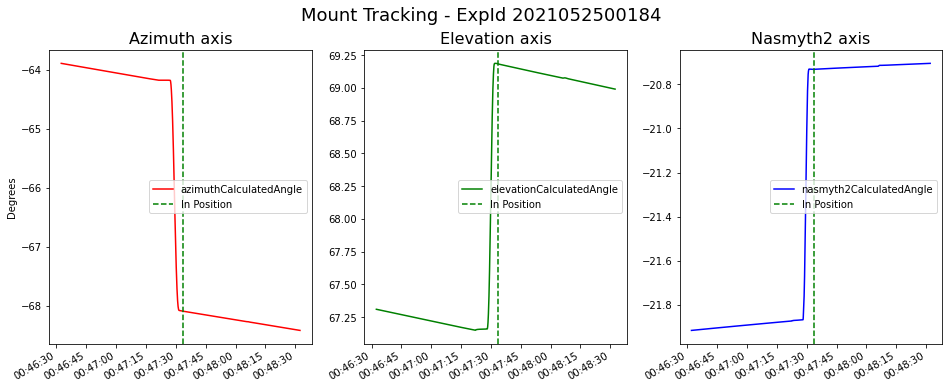

In [11]:
# Get and plot the data
# Note that when it gets the data, it adds another 37 seconds to tstart and tend!!!
# If I change merge_packed_time_series internal_time_scale to 'utc', then it doesn't do this.
mount_position = await client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", ['*'],
                                          tstart, tend)
nasmyth_position = await client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders", ['*'],
                                          tstart, tend)

az = merge_packed_time_series(mount_position, 'azimuthCalculatedAngle', stride=1, internal_time_scale="utc")
el = merge_packed_time_series(mount_position, 'elevationCalculatedAngle', stride=1, internal_time_scale="utc")
rot = merge_packed_time_series(nasmyth_position, 'nasmyth2CalculatedAngle', stride=1, internal_time_scale="utc")

# Plot it
fig = plt.figure(figsize = (16,6))
plt.suptitle(f"Mount Tracking - ExpId {expIds[1]}", fontsize = 18)
# Azimuth axis
plt.subplot(1,3,1)
ax1 = az['azimuthCalculatedAngle'].plot(legend=True, color='red')
ax1.set_title("Azimuth axis", fontsize=16)
ax1.axvline(inPos.isot, color="green", linestyle="--", label="In Position")
ax1.set_ylabel("Degrees")
ax1.legend()

# Elevation axis
plt.subplot(1,3,2)
ax2 = el['elevationCalculatedAngle'].plot(legend=True, color='green')
ax2.set_title("Elevation axis", fontsize=16)
ax2.axvline(inPos.isot, color="green", linestyle="--", label="In Position")
ax2.legend()

# Nasmyth2 rotator axis
plt.subplot(1,3,3)
ax3 = rot['nasmyth2CalculatedAngle'].plot(legend=True, color='blue')
ax3.set_title("Nasmyth2 axis", fontsize=16)
ax3.axvline(inPos.isot, color="green", linestyle="--", label="In Position")
ax3.legend()

plt.savefig(f"/project/cslage/AuxTel/offsets/Tracking_Timebase_{expIds[1]}_25May21.pdf")
